### 1 Setup
#### 1.1 Library and duckdb file import

In [33]:
# EXPLORING DATA

import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# create or connect if it already exists:
con = duckdb.connect("movielensfull33M.duckdb")

#### 1.2 Tables from the original dataset
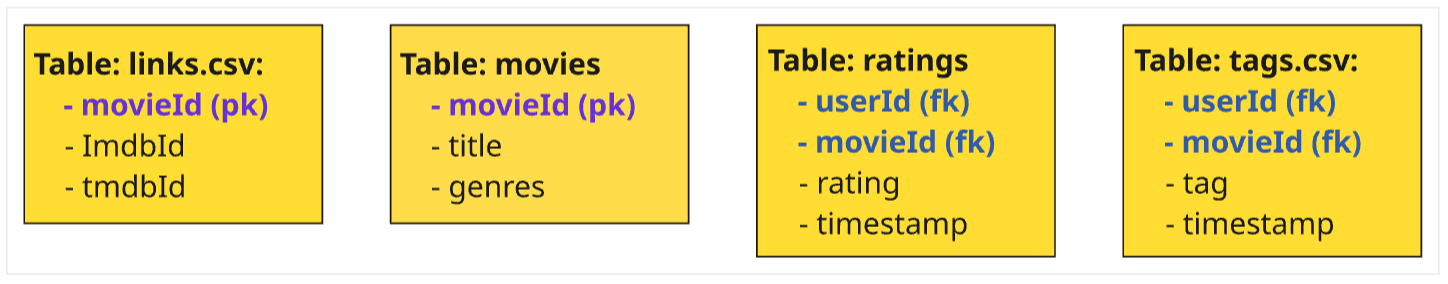



### 2 Research Questions:
#### 2.1 Highest rating movies (with at least 50 ratings)

In [34]:
# Find the 20 movies with the highest rating (with at least 50 ratings)
df1 = con.sql("""
SELECT
    m.title,
    ROUND(AVG(r.rating), 2) AS media_rating,
    COUNT(*)                AS total_ratings
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
HAVING COUNT(*) > 50
ORDER BY media_rating DESC, total_ratings DESC
LIMIT 20
""").df()

df1


,title,media_rating,total_ratings
0,Planet Earth (2006),4.45,3015
1,Planet Earth II (2016),4.45,2041
2,"Shawshank Redemption, The (1994)",4.42,122296
3,Band of Brothers (2001),4.42,2835
4,Cosmos,4.34,625
5,"Godfather, The (1972)",4.33,75004
6,Parasite (2019),4.33,12399
7,Blue Planet II (2017),4.31,1267
8,Twelve Angry Men (1954),4.31,332
9,Twin Peaks (1989),4.30,1132


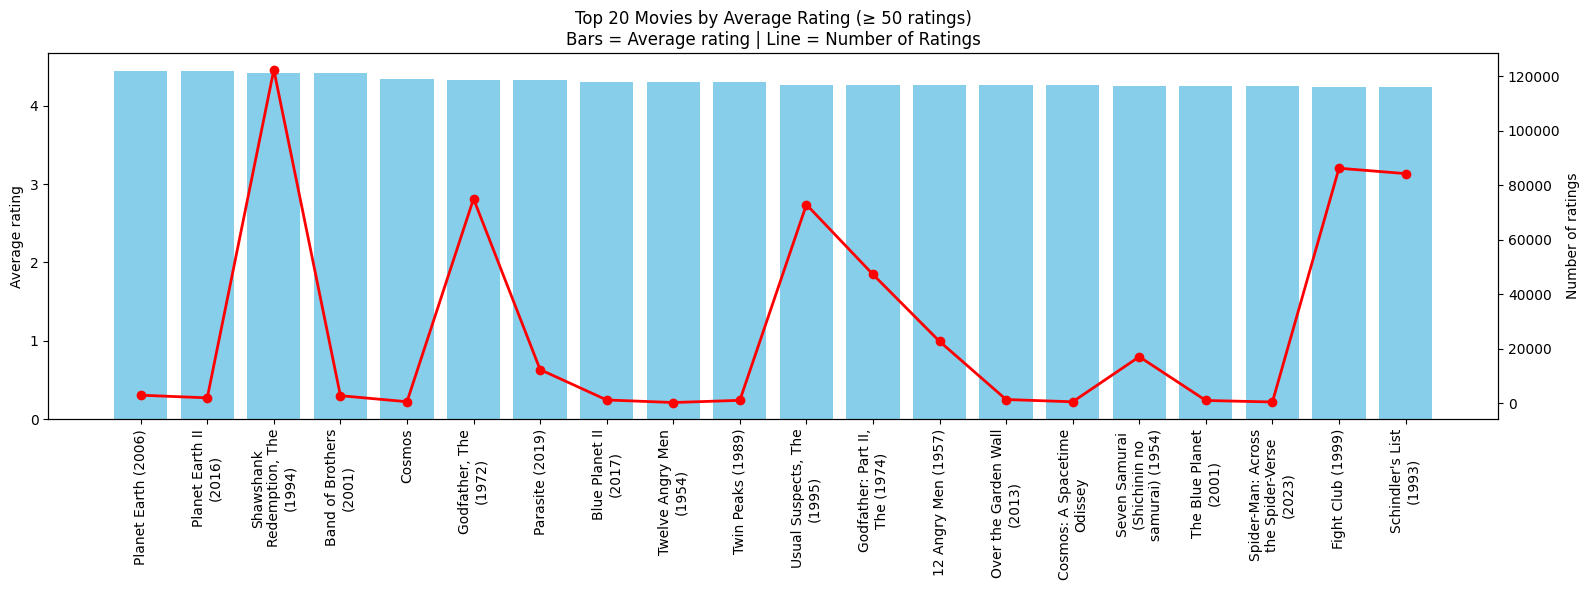

In [35]:
# Combined plot: bars = average rating, line = number of ratings
fig, ax1 = plt.subplots(figsize=(16, 6))

wrapped_titles = [ "\n".join(textwrap.wrap(t, 20)) for t in df1["title"] ]

ax1.bar(df1["title"], df1["media_rating"], color="skyblue")
ax1.set_ylabel("Average rating")
ax1.set_xticks(range(len(df1)))
ax1.set_xticklabels(wrapped_titles, rotation=90, ha="center")

# Line plot
ax2 = ax1.twinx()
ax2.plot(range(len(df1)), df1["total_ratings"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Number of ratings")

plt.title("Top 20 Movies by Average Rating (≥ 50 ratings)\nBars = Average rating | Line = Number of Ratings")
plt.tight_layout()
plt.show()


#### 2.2 Best rated movies

In [36]:
# ranking of the 20 movies with the most ratings

df2 = con.sql("""
SELECT
    m.title,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
ORDER BY total_ratings DESC, media_rating DESC
LIMIT 20
""").df()

df2




,title,total_ratings,media_rating
0,"Shawshank Redemption, The (1994)",122296,4.42
1,Forrest Gump (1994),113581,4.07
2,Pulp Fiction (1994),108756,4.19
3,"Matrix, The (1999)",107056,4.16
4,"Silence of the Lambs, The (1991)",101802,4.15
5,Star Wars: Episode IV - A New Hope (1977),97202,4.09
6,Fight Club (1999),86207,4.24
7,Schindler's List (1993),84232,4.24
8,Jurassic Park (1993),83026,3.69
9,Star Wars: Episode V - The Empire Strikes Back...,80200,4.12


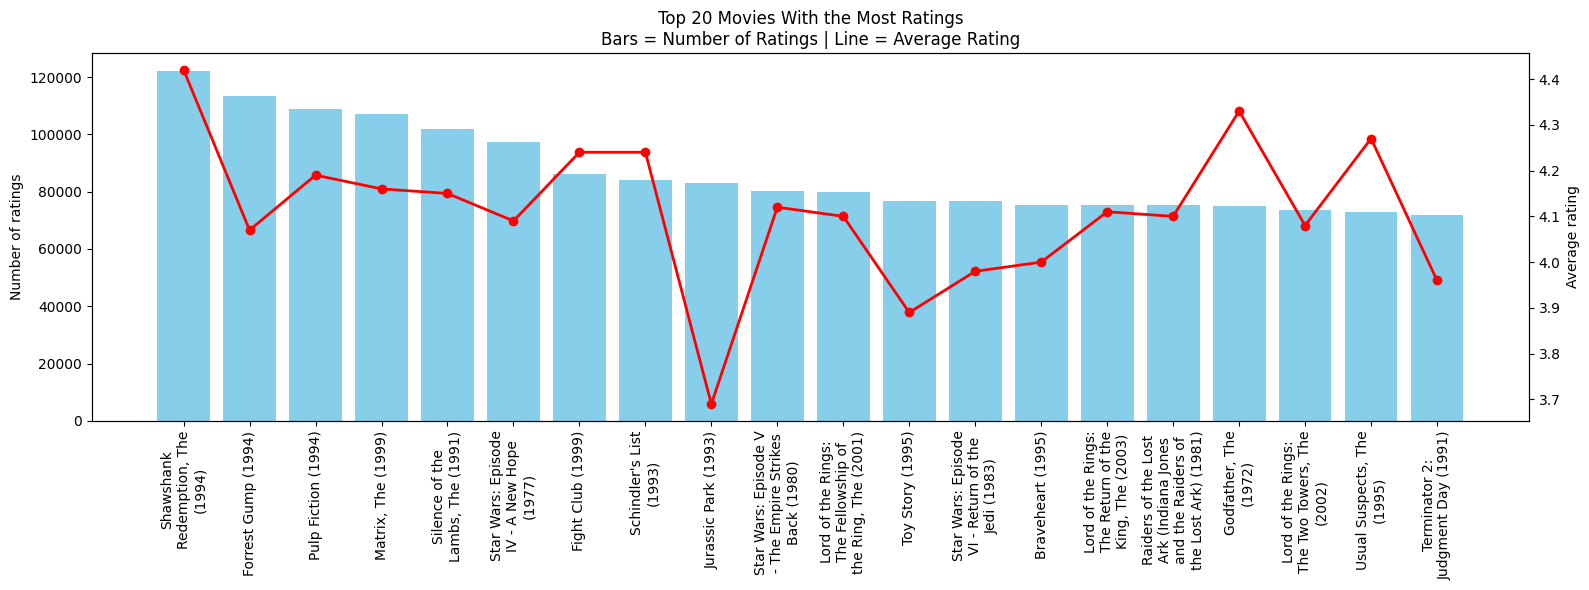

In [37]:
# ranking of the 20 movies with the most ratings
fig, ax1 = plt.subplots(figsize=(16, 6))

# Wrap titles into multiple lines (≈20 chars per line)
wrapped_titles = ["\n".join(textwrap.wrap(t, 20)) for t in df2["title"]]

# Bars = number of ratings (blue)
ax1.bar(df2["title"], df2["total_ratings"], color="skyblue")
ax1.set_ylabel("Number of ratings")
ax1.set_xticks(range(len(df2)))
ax1.set_xticklabels(wrapped_titles, rotation=90, ha="center")  # melhor sem rotação

# Line = average rating (red)
ax2 = ax1.twinx()
ax2.plot(range(len(df2)), df2["media_rating"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Average rating")

plt.title("Top 20 Movies With the Most Ratings\nBars = Number of Ratings | Line = Average Rating")
plt.tight_layout()
plt.show()


#### 2.3 Best movies by Genre (with at least 50 ratings)

In [38]:
# Ranking of movies by genre (with at least 50 ratings)
df3 = con.sql("""
WITH genero_filme AS (
    SELECT
        m.movieId,
        m.title,
        unnest(string_split(m.genres, '|')) AS genre
    FROM movies m
),
stats_genero_filme AS (
    SELECT
        gf.genre,
        gf.movieId,
        gf.title,
        COUNT(*) AS total_ratings,
        AVG(r.rating) AS media_rating
    FROM genero_filme gf
    JOIN ratings r
      ON r.movieId = gf.movieId
    GROUP BY gf.genre, gf.movieId, gf.title
    HAVING COUNT(*) >= 50          
),
ranking_por_genero AS (
    SELECT
        genre,
        movieId,
        title,
        total_ratings,
        media_rating,
        ROW_NUMBER() OVER (
            PARTITION BY genre
            ORDER BY media_rating DESC, total_ratings DESC
        ) AS posicao
    FROM stats_genero_filme
)
SELECT
    genre,
    title,
    ROUND(media_rating, 2) AS media_rating,
    total_ratings
FROM ranking_por_genero
WHERE posicao = 1
ORDER BY genre
""").df()

df3

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,genre,title,media_rating,total_ratings
0,(no genres listed),Cosmos,4.34,625
1,Action,Band of Brothers (2001),4.42,2835
2,Adventure,Over the Garden Wall (2013),4.26,1430
3,Animation,Over the Garden Wall (2013),4.26,1430
4,Children,My Neighbor Totoro (Tonari no Totoro) (1988),4.16,14010
5,Comedy,Parasite (2019),4.33,12399
6,Crime,"Shawshank Redemption, The (1994)",4.42,122296
7,Documentary,Planet Earth II (2016),4.45,2041
8,Drama,Band of Brothers (2001),4.42,2835
9,Fantasy,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.23,35375


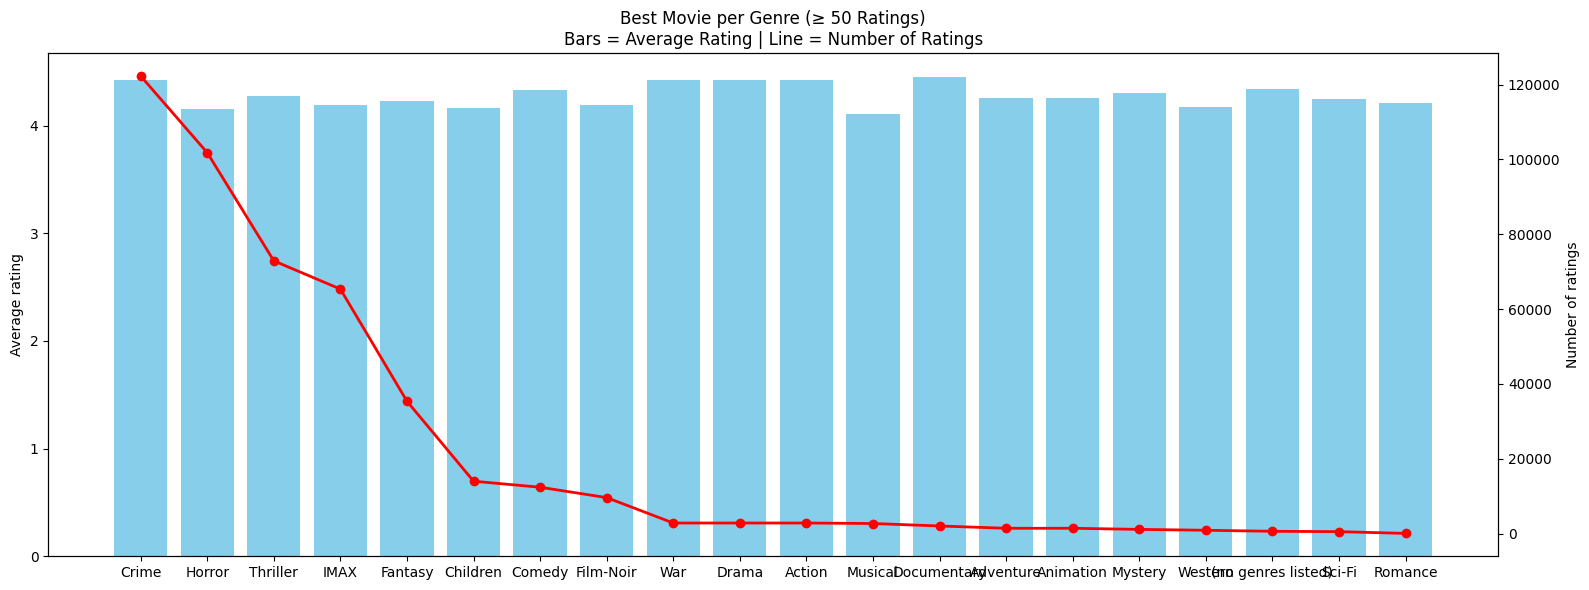

In [39]:
# Sort by number of ratings (descending)
df3_plot = df3.sort_values("total_ratings", ascending=False)

x = np.arange(len(df3_plot))   # 0..N-1

fig, ax1 = plt.subplots(figsize=(16, 6))

# Bars = average rating
ax1.bar(x, df3_plot["media_rating"], color="skyblue")
ax1.set_ylabel("Average rating")

# Line = number of ratings
ax2 = ax1.twinx()
ax2.plot(x, df3_plot["total_ratings"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Number of ratings")

# Genres as x-axis labels
plt.xticks(x, df3_plot["genre"], rotation=90)

plt.title("Best Movie per Genre (≥ 50 Ratings)\nBars = Average Rating | Line = Number of Ratings")
plt.tight_layout()
plt.show()

#### 2.4 Highest-rated movies by genre (with at least 50 ratings)

In [40]:
# ranking of the highest-rated movies by genre (with at least 50 ratings)

con.sql("""
WITH genero_filme AS (
    SELECT
        m.movieId,
        m.title,
        unnest(string_split(m.genres, '|')) AS genre
    FROM movies m
),
stats_genero_filme AS (
    SELECT
        gf.genre,
        gf.movieId,
        gf.title,
        COUNT(*) AS total_ratings,
        AVG(r.rating) AS media_rating
    FROM genero_filme gf
    JOIN ratings r
      ON r.movieId = gf.movieId
    GROUP BY gf.genre, gf.movieId, gf.title
    HAVING COUNT(*) >= 50  -- mantém só filmes com pelo menos 50 avaliações
),
ranking_por_genero AS (
    SELECT
        genre,
        movieId,
        title,
        total_ratings,
        media_rating,
        ROW_NUMBER() OVER (
            PARTITION BY genre
            ORDER BY total_ratings DESC, media_rating DESC
        ) AS posicao
    FROM stats_genero_filme
)
SELECT
    genre,
--    posicao,
    title,
    total_ratings,
    ROUND(media_rating, 2) AS media_rating
FROM ranking_por_genero
WHERE posicao <= 1
ORDER BY genre, posicao
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,genre,title,total_ratings,media_rating
0,(no genres listed),Hereditary (2018),4631,3.87
1,Action,"Matrix, The (1999)",107056,4.16
2,Adventure,Star Wars: Episode IV - A New Hope (1977),97202,4.09
3,Animation,Toy Story (1995),76813,3.89
4,Children,Toy Story (1995),76813,3.89
5,Comedy,Forrest Gump (1994),113581,4.07
6,Crime,"Shawshank Redemption, The (1994)",122296,4.42
7,Documentary,Bowling for Columbine (2002),16608,3.69
8,Drama,"Shawshank Redemption, The (1994)",122296,4.42
9,Fantasy,"Lord of the Rings: The Fellowship of the Ring,...",79940,4.10


#### 2.5 Most common tags

In [41]:
# Most frequent tag words

con.sql("""
SELECT
    LOWER(TRIM(word)) AS palavra,
    COUNT(*) AS total
FROM (
    SELECT unnest(string_split(tag, ' ')) AS word
    FROM tags
)
WHERE palavra <> ''
  AND LENGTH(palavra) > 2
  AND palavra NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are')
GROUP BY palavra
ORDER BY total DESC
LIMIT 30
""").df()

,palavra,total
0,comedy,32686
1,based,22092
2,ending,19849
3,dark,18455
4,film,17807
5,relationship,17426
6,great,17283
7,nudity,16873
8,sci-fi,16492
9,action,15728


#### 2.6 Most repeated tags

In [42]:

# Most frequent tag words per movie

df_tags=con.sql("""
WITH palavras_por_filme AS (
    SELECT
        t.movieId,
        LOWER(TRIM(word)) AS palavra,
        COUNT(*) AS total
    FROM (
        SELECT movieId, unnest(string_split(tag, ' ')) AS word
        FROM tags
    ) t
    WHERE palavra <> ''
      AND LENGTH(palavra) > 2
      AND palavra NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are', 'was')
    GROUP BY t.movieId, palavra
),
ranking_por_filme AS (
    SELECT
        movieId,
        palavra,
        total,
        ROW_NUMBER() OVER (PARTITION BY movieId ORDER BY total DESC) AS posicao
    FROM palavras_por_filme
)
SELECT
    m.movieId,
    m.title,
    r.palavra,
    r.total
FROM ranking_por_filme r
JOIN movies m USING (movieId)
WHERE r.posicao <= 5
ORDER BY r.total DESC
LIMIT 20
""").df()

df_tags

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,movieId,title,palavra,total
0,260,Star Wars: Episode IV - A New Hope (1977),space,1684
1,260,Star Wars: Episode IV - A New Hope (1977),sci-fi,1538
2,260,Star Wars: Episode IV - A New Hope (1977),classic,1089
3,109487,Interstellar (2014),space,809
4,260,Star Wars: Episode IV - A New Hope (1977),adventure,807
5,296,Pulp Fiction (1994),comedy,707
6,296,Pulp Fiction (1994),tarantino,700
7,318,"Shawshank Redemption, The (1994)",ending,665
8,2571,"Matrix, The (1999)",reality,663
9,2959,Fight Club (1999),ending,640


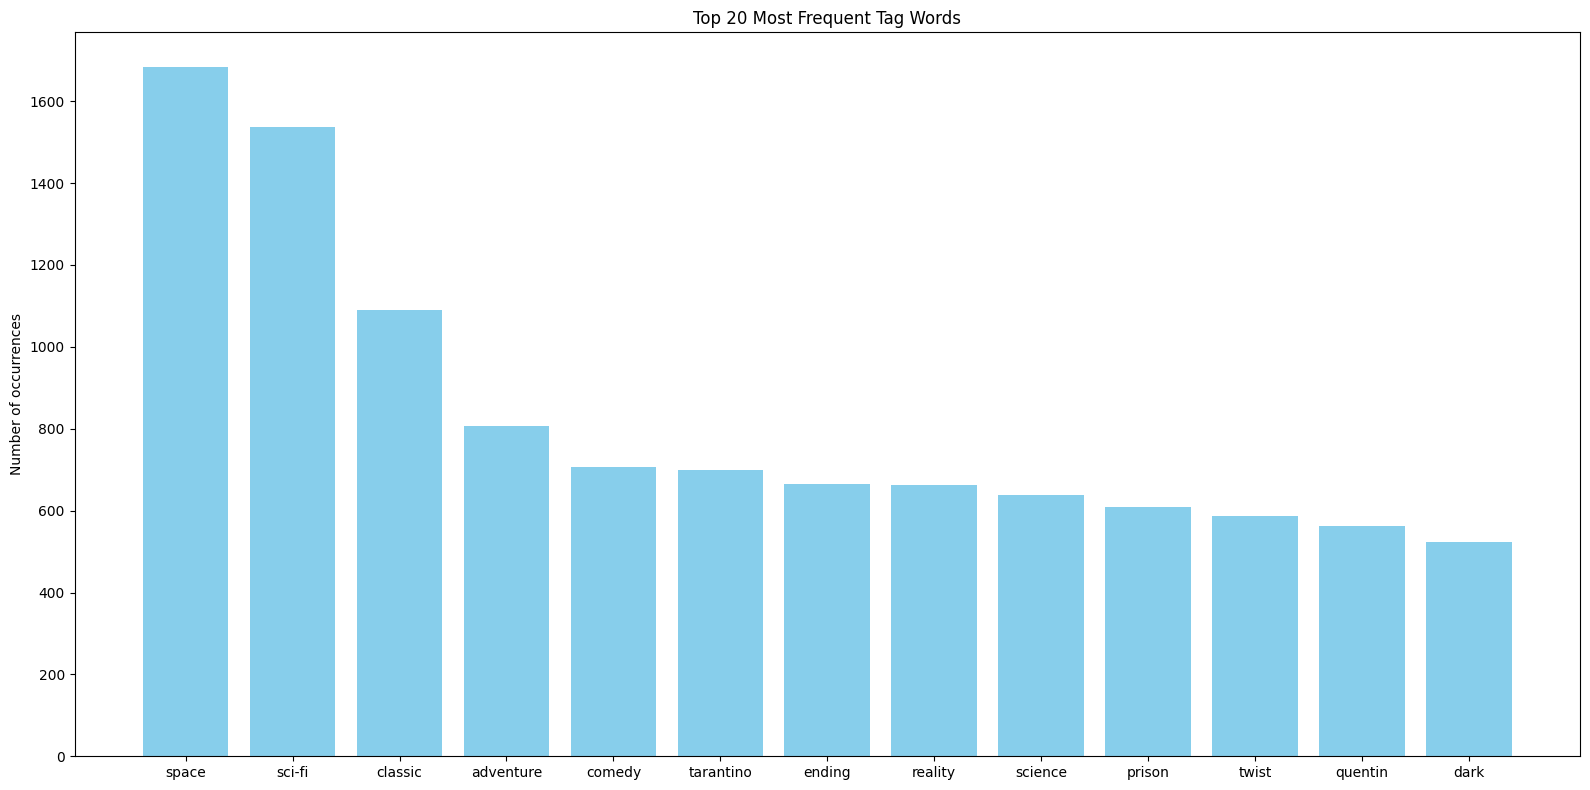

In [43]:
# Top 20 repeated tag by movie
df_top = df_tags.sort_values("total", ascending=False).head(20)

plt.figure(figsize=(16, 8))
plt.bar(df_top["palavra"], df_top["total"], color="skyblue")

plt.title("Top 20 Most Frequent Tag Words")
plt.ylabel("Number of occurrences")
plt.xticks(rotation=0, ha="center")

plt.tight_layout()
plt.show()

#### 2.7 Users with the highest number of ratings and their average score

In [44]:
# “Identify the users with the highest number of ratings and their average score (limit 20)”

con.sql("""
SELECT
    r.userId,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
GROUP BY r.userId
ORDER BY total_ratings DESC, media_rating DESC
LIMIT 20
""").df()


,userId,total_ratings,media_rating
0,189614,33332,3.08
1,48766,9554,2.57
2,207216,9178,3.28
3,175998,9016,3.18
4,76618,8919,2.54
5,230765,7719,3.41
6,184775,7535,2.82
7,236260,7488,3.21
8,233891,7372,2.64
9,214831,7266,1.55


In [45]:
# “Identify the users with the highest number of ratings and their average score”

df_users =con.sql("""
SELECT
    r.userId,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
GROUP BY r.userId
ORDER BY total_ratings DESC, media_rating DESC
""").df()


In [46]:
# Obtain basic statistics about the number of ratings per user
serie = df_users["total_ratings"]

mean_val = serie.mean()
std_val = serie.std()
median_val = serie.median()
mode_val = serie.mode()[0]          
min_val = serie.min()
max_val = serie.max()
desc = serie.describe()

print(
    f"Mean = {mean_val:.2f}\n"
    f"Standard deviation = {std_val:.2f}\n"
    f"Median = {median_val:.2f}\n"
    f"Mode = {mode_val}\n"
    f"Minimum = {min_val}\n"
    f"Maximum = {max_val}\n"
)



Mean = 102.22
Standard deviation = 232.15
Median = 31.00
Mode = 15
Minimum = 1
Maximum = 33332



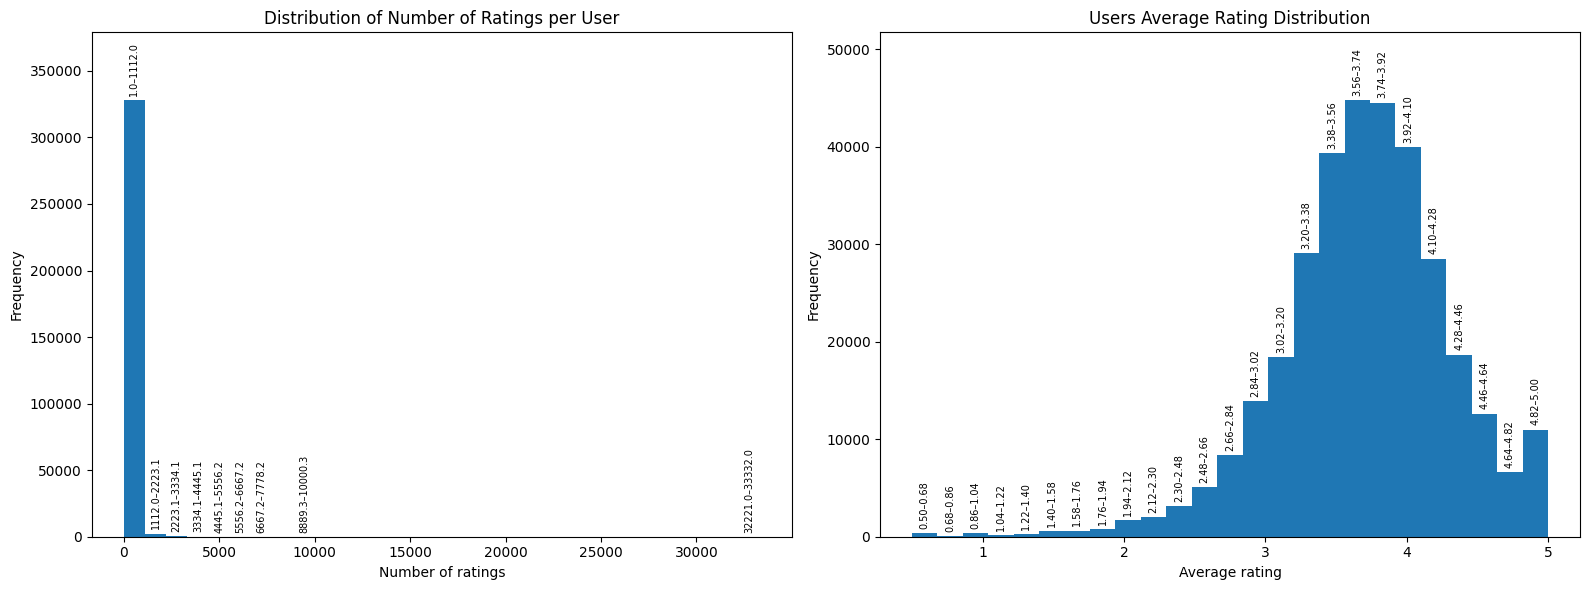

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram: number of ratings per user
counts, bins, patches = axes[0].hist(df_users["total_ratings"], bins=30)
axes[0].set_title("Distribution of Number of Ratings per User")
axes[0].set_xlabel("Number of ratings")
axes[0].set_ylabel("Frequency")



# Add label = interval for each bar
for i, patch in enumerate(patches):
    height = patch.get_height()
    if height > 0:
        interval_label = f"{bins[i]:.1f}–{bins[i+1]:.1f}"
        axes[0].annotate(
            interval_label,
            xy=(patch.get_x() + patch.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=7,
            rotation=90
        )

# Histogram: average rating per user
counts2, bins2, patches2 = axes[1].hist(df_users["media_rating"], bins=25)
axes[1].set_title("Users Average Rating Distribution")
axes[1].set_xlabel("Average rating")
axes[1].set_ylabel("Frequency")

# Add interval labels to second plot
for i, patch in enumerate(patches2):
    height = patch.get_height()
    if height > 0:
        interval_label = f"{bins2[i]:.2f}–{bins2[i+1]:.2f}"
        axes[1].annotate(
            interval_label,
            xy=(patch.get_x() + patch.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=7,
            rotation=90
        )

axes[0].set_ylim(top = axes[0].get_ylim()[1] * 1.1)
axes[1].set_ylim(top = axes[1].get_ylim()[1] * 1.1)

plt.tight_layout()
plt.show()


#### 2.8 Best 20 movies considering a Weighted classification (50% avg rating, 50% scaled nº ratings)

In [48]:
# Weighted top20 (50% avg rating, 50% scaled nº ratings) — exclui filmes com poucas avaliações
MIN_RATINGS = 50

df_weighted = con.sql(f"""
WITH movie_stats AS (
    SELECT
        m.movieId,
        m.title,
        AVG(r.rating) AS avg_rating,
        COUNT(*) AS total_ratings
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.movieId, m.title
    HAVING COUNT(*) >= {MIN_RATINGS}          -- filtro para excluir filmes com poucas avaliações
),
with_minmax AS (
    SELECT
        *,
        MIN(total_ratings) OVER () AS min_ratings,
        MAX(total_ratings) OVER () AS max_ratings
    FROM movie_stats
),
scored AS (
    SELECT
        movieId,
        title,
        ROUND(avg_rating, 2) AS avg_rating,
        total_ratings,
        -- escala linear do total_ratings para o intervalo [1,5]
        CASE
            WHEN max_ratings = min_ratings THEN 3.0
            ELSE 1.0 + 4.0 * (total_ratings - min_ratings) / (max_ratings - min_ratings)
        END AS scaled_count_1_5
    FROM with_minmax
)
SELECT
    title,
    avg_rating,
    total_ratings,
    ROUND(scaled_count_1_5, 2) AS scaled_count_1_5,
    ROUND(0.5 * avg_rating + 0.5 * scaled_count_1_5, 2) AS weighted_score
FROM scored
ORDER BY weighted_score DESC, total_ratings DESC
LIMIT 20
""").df()

df_weighted


,title,avg_rating,total_ratings,scaled_count_1_5,weighted_score
0,"Shawshank Redemption, The (1994)",4.42,122296,5.00,4.71
1,Forrest Gump (1994),4.07,113581,4.71,4.39
2,Pulp Fiction (1994),4.19,108756,4.56,4.37
3,"Matrix, The (1999)",4.16,107056,4.50,4.33
4,"Silence of the Lambs, The (1991)",4.15,101802,4.33,4.24
5,Star Wars: Episode IV - A New Hope (1977),4.09,97202,4.18,4.13
6,Fight Club (1999),4.24,86207,3.82,4.03
7,Schindler's List (1993),4.24,84232,3.75,4.00
8,"Godfather, The (1972)",4.33,75004,3.45,3.89
9,Star Wars: Episode V - The Empire Strikes Back...,4.12,80200,3.62,3.87


#### 2.9 Weighted Movie Scores 
##### 2.9.1 Weighted Movie Scores Grouped by years
Years with at least 100 Films per Year and movies with at least 50 ratings

In [49]:
MIN_RATINGS = 50

df_year = con.sql(f"""
WITH movie_stats AS (
    SELECT
        m.movieId,
        m.title,
        AVG(r.rating) AS avg_rating,
        COUNT(*) AS total_ratings
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.movieId, m.title
    HAVING COUNT(*) >= {MIN_RATINGS}
),
with_minmax AS (
    SELECT
        *,
        MIN(total_ratings) OVER () AS min_ratings,
        MAX(total_ratings) OVER () AS max_ratings
    FROM movie_stats
),
scored_with_year_str AS (
    SELECT
        movieId,
        title,
        ROUND(avg_rating, 2) AS avg_rating,
        total_ratings,
        CASE
            WHEN max_ratings = min_ratings THEN 3.0
            ELSE 1.0 + 4.0 * (total_ratings - min_ratings) / (max_ratings - min_ratings)
        END AS scaled_count_1_5,
        regexp_extract(title, '.*\\((\\d{{4}})\\)$', 1) AS year_str
    FROM with_minmax
),
scored AS (
    SELECT
        movieId,
        title,
        avg_rating,
        total_ratings,
        scaled_count_1_5,
        CAST(year_str AS INTEGER) AS year
    FROM scored_with_year_str
    WHERE year_str IS NOT NULL AND year_str <> ''
)
SELECT
    year,
    AVG(0.5 * avg_rating + 0.5 * scaled_count_1_5) AS avg_weighted_score,
    COUNT(*) AS n_movies
FROM scored
GROUP BY year
HAVING COUNT(*) >= 101        -- só anos com 100+ filmes
ORDER BY year
""").df()

df_year


,year,avg_weighted_score,n_movies
0,1980,2.102119,153
1,1981,2.109371,154
2,1982,2.154663,144
3,1983,2.156029,123
4,1984,2.152306,139
5,1985,2.144734,161
6,1986,2.103804,181
7,1987,2.079999,204
8,1988,2.095876,212
9,1989,2.104455,204


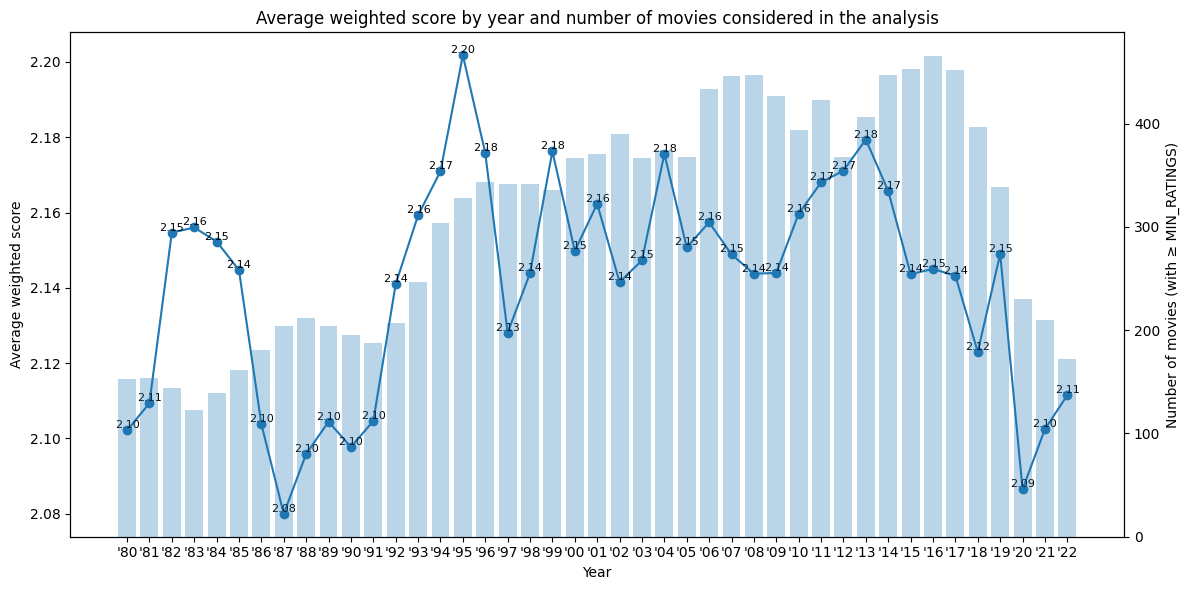

In [50]:
# Yearly Weighted Movie Scores 
# Years with at least 100 Films per Year and movies with at least 50 ratings
fig, ax1 = plt.subplots(figsize=(12, 6))

years = df_year["year"]
scores = df_year["avg_weighted_score"]
counts = df_year["n_movies"]

# --- Criar labels com apenas os últimos 2 dígitos ---
year_labels = years.astype(str).apply(lambda x: "'" + x[-2:])

# 1) Linha do score (eixo esquerdo)
ax1.plot(years, scores, marker="o")
ax1.set_xlabel("Year")
ax1.set_ylabel("Average weighted score")
ax1.tick_params(axis="y")

# Mostrar valores nos pontos
for x, y in zip(years, scores):
    ax1.text(x, y, f"{y:.2f}", fontsize=8, ha="center", va="bottom")

# 2) Barras do nº de filmes (eixo direito)
ax2 = ax1.twinx()
ax2.bar(years, counts, alpha=0.3)
ax2.set_ylabel("Number of movies (with ≥ MIN_RATINGS)")
ax2.tick_params(axis="y")

# --- Aplicar as labels reduzidas no eixo X ---
plt.xticks(years, year_labels, rotation=45)

plt.title("Average weighted score by year and number of movies considered in the analysis")
plt.tight_layout()
plt.show()


##### 2.9.2 Weighted Movie Scores Grouped by decades
Years with at least 100 Films per Year and movies with at least 50 ratings

In [51]:
# Movies — Weighted score aggregated by decade (≥ MIN_RATINGS per movie, ≥ 100 movies per decade)

df_decade = con.sql(f"""
WITH movie_stats AS (
    SELECT
        m.movieId,
        m.title,
        AVG(r.rating) AS avg_rating,
        COUNT(*) AS total_ratings
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.movieId, m.title
    HAVING COUNT(*) >= {MIN_RATINGS}
),
with_minmax AS (
    SELECT
        *,
        MIN(total_ratings) OVER () AS min_ratings,
        MAX(total_ratings) OVER () AS max_ratings
    FROM movie_stats
),
scored_with_year_str AS (
    SELECT
        movieId,
        title,
        ROUND(avg_rating, 2) AS avg_rating,
        total_ratings,
        CASE
            WHEN max_ratings = min_ratings THEN 3.0
            ELSE 1.0 + 4.0 * (total_ratings - min_ratings) / (max_ratings - min_ratings)
        END AS scaled_count_1_5,
        regexp_extract(title, '.*\\((\\d{{4}})\\)$', 1) AS year_str
    FROM with_minmax
),
scored AS (
    SELECT
        movieId,
        title,
        avg_rating,
        total_ratings,
        scaled_count_1_5,
        CAST(year_str AS INTEGER) AS year
    FROM scored_with_year_str
    WHERE year_str IS NOT NULL AND year_str <> ''
),
with_scores AS (
    SELECT
        year,
        (0.5 * avg_rating + 0.5 * scaled_count_1_5) AS weighted_score
    FROM scored
)
SELECT
    CAST(FLOOR(year / 10) * 10 AS INTEGER) AS decade,
    ROUND(AVG(weighted_score), 3) AS avg_score_decade,
    COUNT(*) AS movies_in_decade
FROM with_scores
GROUP BY decade
HAVING COUNT(*) >= 100          
ORDER BY decade;
""").df()

df_decade


,decade,avg_score_decade,movies_in_decade
0,1930,2.298,226
1,1940,2.291,353
2,1950,2.283,482
3,1960,2.262,691
4,1970,2.223,905
5,1980,2.117,1675
6,1990,2.155,2830
7,2000,2.152,3989
8,2010,2.155,4144
9,2020,2.101,655


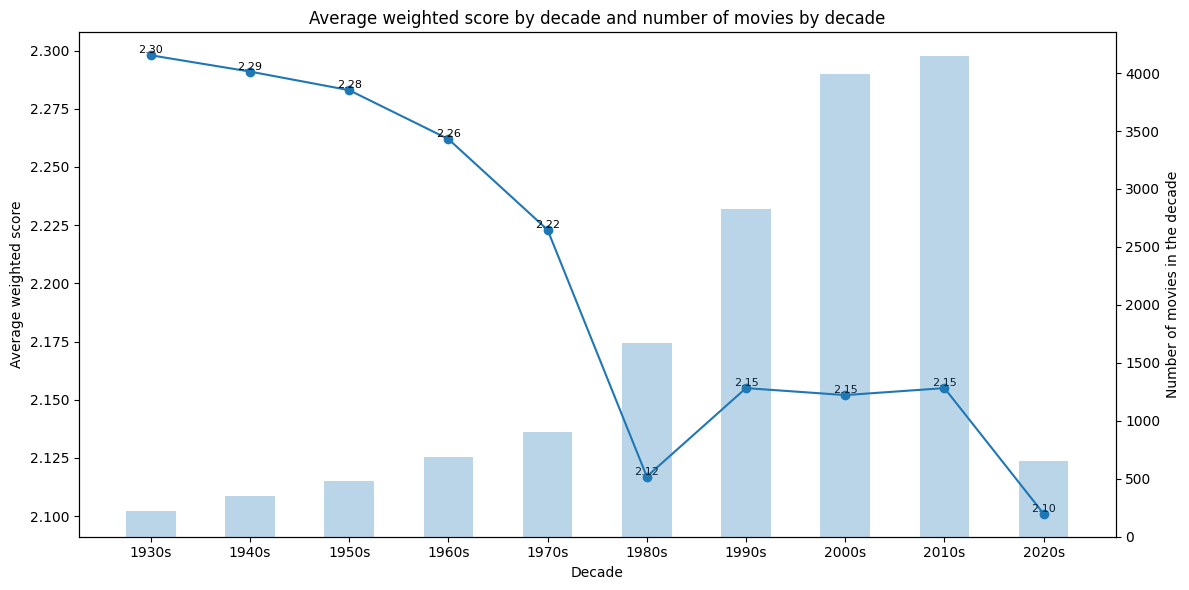

In [52]:
# Decade vs Average Weighted Score and number of movies
decades = df_decade["decade"].astype(int)
scores = df_decade["avg_score_decade"]
counts = df_decade["movies_in_decade"]

# labels bonitos: 1980s, 1990s, ...
decade_labels = decades.astype(str) + "s"

fig, ax1 = plt.subplots(figsize=(12, 6))

# 1) Linha com o rating médio por década (eixo da esquerda)
ax1.plot(decades, scores, marker="o")
ax1.set_xlabel("Decade")
ax1.set_ylabel("Average weighted score")
ax1.tick_params(axis="y")

# valores em cima dos pontos
for x, y, label in zip(decades, scores, decade_labels):
    ax1.text(x, y, f"{y:.2f}", fontsize=8, ha="center", va="bottom")

# 2) Barras com nº de filmes na década (eixo da direita)
ax2 = ax1.twinx()
ax2.bar(decades, counts, width=5, alpha=0.3)
ax2.set_ylabel("Number of movies in the decade")
ax2.tick_params(axis="y")


# usar labels '1980s', '1990s' no eixo X
plt.xticks(decades, decade_labels, rotation=45)

plt.title("Average weighted score by decade and number of movies by decade")
plt.tight_layout()
plt.show()


#### 2.10Most common tags and corresponding average score

In [ ]:
df_tags = con.sql(f"""
SELECT
    word,
    COUNT(*) AS total,
    ROUND(AVG(r.rating), 3) AS avg_rating
FROM (
    SELECT
        t.movieid,
        LOWER(TRIM(w)) AS word
    FROM tags t
    CROSS JOIN UNNEST(split(t.tag, ' ')) AS u(w)
) words
JOIN ratings r
    ON r.movieid = words.movieid
WHERE word <> ''
  AND LENGTH(word) > 2
  AND word NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are')
GROUP BY word
ORDER BY total DESC
LIMIT 30
""").df()

df_tags

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,word,total,avg_rating
0,comedy,598403267,3.900
1,ending,536805463,4.081
2,great,518142242,4.079
3,sci-fi,511974975,3.934
4,dark,443726615,4.005
5,action,394239353,3.869
6,classic,378907369,4.066
7,space,359293068,3.971
8,twist,353110550,4.089
9,atmospheric,306803609,4.022


The previous query took 14 m as 12s to complete!

#### Fechar a ligação

In [53]:
con.close()
print("Ligação fechada.")

Ligação fechada.


### 3 Conclusions
#### Conclusions on Data Exploration on the 33M dataset:
- From the top20 best rated movies (>=50 ratings), there's a big diversity on the year of production, being the ratings between 4.45 and 4.24
- From the top20 movies with the most number of ratings (>71K ratings), 1994 scores the top3 most rated films with "Shawshank Redemption", "Forrest Gump" and "Pulp Fiction", with >108K ratings. On this top20, 12 were from the '90s
- When looking per category the picture does not change much -> on the top20 best rated movies (>=50 ratings), all top20 categories are led by a big diversity of movies when it comes to year of production, and the ratings vary between 4.11 and 4.45. 
- The same happens when looking at the top20 categories, the '90s produced films are the ones with the highest number of ratings in most of the categories(15 out of 20)
- Within the top most frequent tags, we have "comedy" with +32K ratings, based with +22K ratings, ending with +19K.
- The film "Star Wars IV" was a especially tagged movie, with the 5 of the most common tags out of the top20 most common tags: "space", "sci-fi", "classic", "adventure", and "science".
- The distribution of the average ratings per user is left skewed
- Assuming a new score composed by rating (50% - quality) and number of reviews (50% - popularity), the findings would be:
    - The top3 best movies ever, would be the same three from 1994 ("Shawshank Redemption", "Forrest Gump" and "Pulp Fiction")
    - At the top20, the only three films from the 21st century in this list are part of the trilogy of "Lord of the Rings" (#11, #13, #16). in the same top20, 11 movies are part of the '90s.
    - Merging all movies from the same year with this new score we conclude that:
        - 1995 was the best year ever, with 2.2 score, followed by 1996, 2004 and 2023 with 2.18 score.
        - 1994, 1995 and 1996 were the best three-consecutive years ever, with scores. The golden era of cinema?
        - 2020 was one of the the worst years for cinema (pandemic), with a still slow recovery since this year (according to available data)
        - When looking at decades, the '90s, '00s and '10s have exacly the same score - 2.15, but the number of movies published increased substantially (from 2.8K in '90s to 4.1K in '10s)


#### Conclusions on Data Exploration between 100K and 33M datasets:
- Similar top20 best rated movies and movies with the most ratings.
- Similar best rated and most rated movie top20
- Most frequent tags in 100K are different, being the top3 dominated by "netflix", "queue" and "comedy"
- The same tags analysis is dominated by "Star Wars IV" in the 33M analysis (5/20). However, when looking at the 100K dataset, another movie is dominating the top20 - "Pulp Fiction" with also 5/20 tags ("violence", "dialogue", "soundtrack", "nonlinear", "cult")
- When looking at the "new score" also seen that:
    - same top3 occupied by 1994 movies
    - most of the analysis on years and analysis is lost, because the conditions of +100 movies per year and +50ratings per movie are not met.



##Top Tag Words with Their Average Ratings

Running this query over the full 33M–rating dataset in DuckDB was not feasible: the intermediate result becomes extremely large after exploding all tag words and joining them with every rating for each movie. In practice, this leads to billions of intermediate rows, which DuckDB cannot process in memory for this workload.

Using Athena, however, the query successfully completed in about 7 minutes, thanks to Athena’s distributed execution engine and the ability to scale the join and aggregation stages across multiple workers. This allowed us to compute global tag-word statistics at the 33M scale.

The results show several clear patterns:

- __Genre-like terms__ (e.g., comedy, sci-fi, action, fantasy, adventure) dominate the most frequent words. These reflect how users tag movies by category more than by detailed attributes.

- __Qualitative descriptors__ (e.g great, dark, classic, atmospheric, surreal) also appear frequently, often associated with above-average ratings.

- __Words linked to narrative elements__ (e.g ending, twist, story, plot) tend to have higher average ratings, suggesting that users apply these tags more often to well-received films.

- __Specific thematic or stylistic tags__ (e.g psychology, oscar, soundtrack, war, violence) also appear with relatively strong average ratings.

Overall, the combination of tag frequency and average rating highlights how users describe and perceive movies: popular tags cluster around genre, tone, and key narrative features, and many high-frequency words correspond to films with ratings close to 4.0.